## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.dataloader import DataLoader

## Get Dataset

Download the CIFAR 10 dataset from the torchvision module. The lengths of the training and testing data, and classes are printed.

In [2]:
transformer = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download data
train_data = datasets.CIFAR10(root = r"c:\path", download=True, train=True, transform=transformer)
test_data = datasets.CIFAR10(root = r"c:\path", download=True, train=False, transform=transformer)
classes = train_data.classes

# Load data batch
BATCH_SIZE = 16
train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

print(f"training data: {len(train_data)}")
print(f"testing data: {len(test_data)}")
print(classes)

Files already downloaded and verified
Files already downloaded and verified
training data: 50000
testing data: 10000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Explore Dataset

Check if the classes in dataset is balanced. The frequency of each class is the same for this dataset

In [3]:
count_train = {}
count_test = {}

for label in classes:
  count_train[label] = 0
  count_test[label] = 0

for data in train_data:
  count_train[classes[data[1]]] += 1

for data in test_data:
  count_test[classes[data[1]]] += 1

print(count_train)
print(count_test)

{'airplane': 5000, 'automobile': 5000, 'bird': 5000, 'cat': 5000, 'deer': 5000, 'dog': 5000, 'frog': 5000, 'horse': 5000, 'ship': 5000, 'truck': 5000}
{'airplane': 1000, 'automobile': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}


Plot out a few examples and show their label.

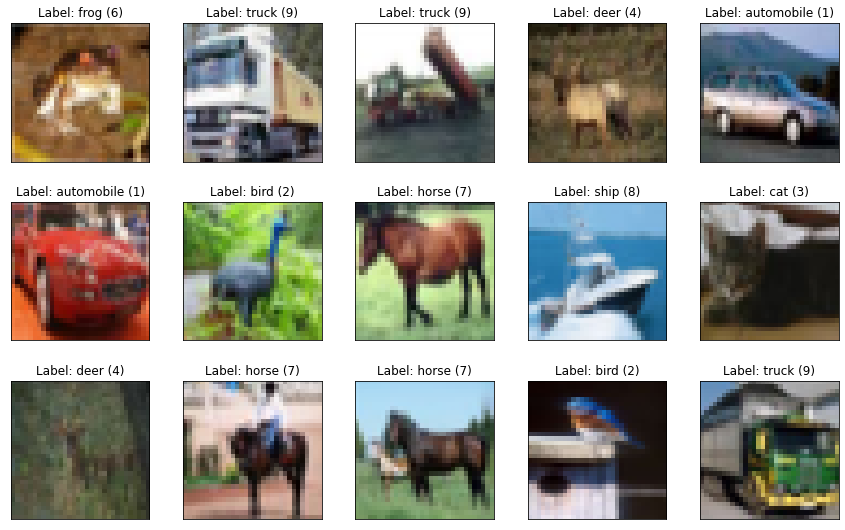

In [4]:
def show_examples(images, start, end, num_row, num_col):
  fig = plt.figure(figsize=(12, 10))
  for i in range(start, end):
    label = images[i][1]
    img = images[i][0] / 2 + 0.5
    title = 'Label: {} ({})'.format(classes[label], str(label))
    plt.subplot(num_row, num_col,i - start +1)
    plt.tight_layout()
    plt.imshow(img.permute(1, 2, 0))
    plt.title(title)
    plt.xticks([])
    plt.yticks([])

def show_example(img, label):
  title = 'Label: {} ({})'.format(classes[label], str(label))
  plt.title(title)
  plt.imshow(img.permute(1, 2, 0))

show_examples(train_data, 0, 15, 4, 5)

## Setting up GPU

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


## Define Model

Define a net class that has 2 convolutional layer and 2 fully connected layer. The forward function defines how the inputs are passed through the network.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv_layer = nn.Sequential(
        # Conv layer block 1
        nn.Conv2d(3, 32, 3, 1, 1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Conv2d(32, 64, 3, 1, 1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),

        # Conv layer block 2
        nn.Conv2d(64, 128, 3, 1, 1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, 3, 1, 1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),
        nn.Dropout2d(p=0.05),

        # Conv layer block 3
        nn.Conv2d(128, 256, 3, 1, 1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, 3, 1, 1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),
    )

    # Fully connected layer
    self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(4096, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(512, 10),
        nn.Softmax(dim=1),
    )


  def forward(self, x):
    x = self.conv_layer(x)
    x = x.view(-1, 4096)
    x = self.fc_layer(x)
    return x

net = Net().to(device)

In [7]:
# define optimizer and loss
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
loss_function = nn.MSELoss()

## Save checkpoint and best model

In [8]:
import shutil

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [9]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to saved checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

## Training and Validation

The forward pass function passes a batch of input to the network. It returns the accuracy and loss of the pass. If train is set to True, the function will calculate gradient and modify the parameters of the network. 

In [10]:
def forward_pass(X, y, train=False):
  if train:
    net.zero_grad()

  X = X.to(device)
  y = torch.Tensor([np.eye(10)[i] for i in y]) # convert to one hot encoding
  y = y.to(device)

  outputs = net(X.view(-1, 3, 32, 32))
  matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
  acc = matches.count(True) / len(matches)
  loss = loss_function(outputs, y)

  if train:
    loss.backward()
    optimizer.step()

  return acc, loss

The test function is used to calculate the accuracy and loss based on a validation set from the test set.

In [11]:
from torch.utils.data import Subset

# Validation set
def test(size=32):
  test_range = list(range(0, size))
  subset = Subset(test_data, test_range)
  validation_loader = DataLoader(subset, size)
  for data in validation_loader:
    X = data[0]
    y = data[1]
    val_acc, val_loss = forward_pass(X, y)
    return val_acc, val_loss

The train function trains the models and log the accuracy, loss, validation accuracy, validation loss every 50 steps

In [12]:
import time
from tqdm import tqdm

MODEL_NAME = f"model_7"

def train(net):
  # Initialize variables
  EPOCHS = 30
  valid_loss_min = np.Inf
  checkpoint_path = f"./checkpoint/current_checkpoint_{MODEL_NAME}.pt"
  best_model_path = f"./best_model/best_{MODEL_NAME}.pt"

  with open("model.log", "a") as f:
    for epoch in tqdm(range(EPOCHS), position=0, leave=True):
      for i, data in enumerate(train_loader):
        X = data[0]
        y = data[1]

        # Training data
        acc, loss = forward_pass(X, y, train=True)

      # Validate data
      val_acc, val_loss = test(size=200)
      f.write(f"{MODEL_NAME},{round(time.time(),3)},{epoch},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")

      # create checkpoint variable and add important data
      checkpoint = {
          'epoch': epoch + 1,
          'valid_loss_min': val_loss,
          'state_dict': net.state_dict(),
          'optimizer': optimizer.state_dict(),
      }
      
      # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
      
      # save the model if validation loss has decreased
      if val_loss <= valid_loss_min:
          # save checkpoint as best model
          save_ckp(checkpoint, True, checkpoint_path, best_model_path)
          valid_loss_min = val_loss


train(net)

100%|██████████| 60/60 [27:01<00:00, 27.02s/it]


## Evaluate Model

Plot the graph for the accuracy and loss.

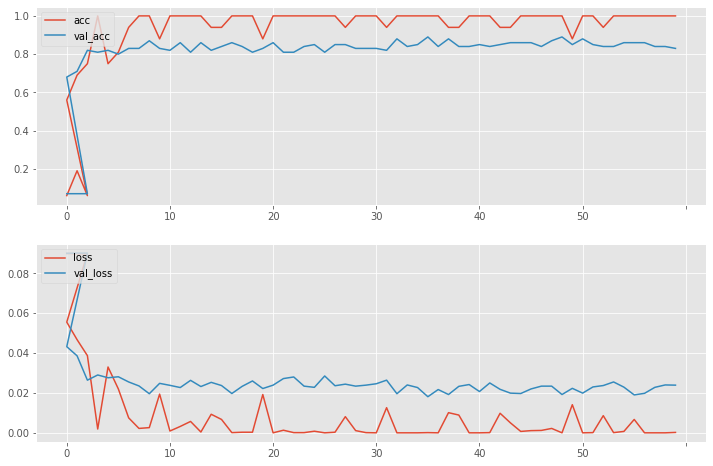

In [13]:
style.use("ggplot")

model_name = MODEL_NAME

def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    epochs = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, epoch, acc, loss, val_acc, val_loss = c.split(",")

            epochs.append(epoch)
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fig = plt.figure(figsize=(12,8))

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

    list_range = [i for i in range(0, 150, 10)]
    ax1.set_xticks(list_range)
    ax2.set_xticks(list_range)
    
    ax1.plot(epochs, accuracies, label="acc")
    ax1.plot(epochs, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(epochs,losses, label="loss")
    ax2.plot(epochs,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)

The graph can be smoothen by using exponential weighted function

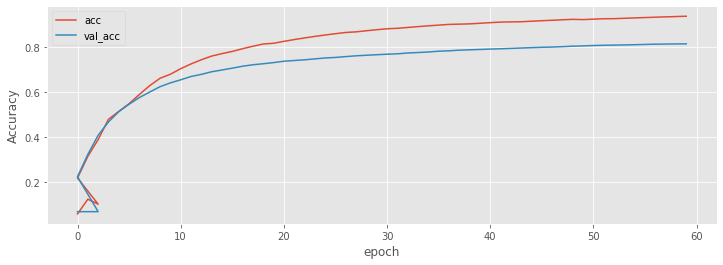

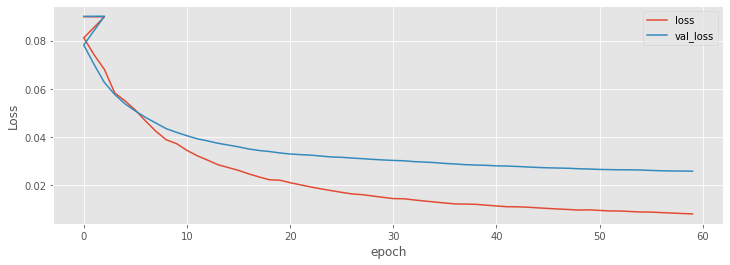

In [14]:
def create_acc_loss_graph(model_name):
    style.use('ggplot')
    data = pd.read_csv('model.log', names=['model_name', 'timestamp', 'epoch', 'acc', 'loss', 'val_acc', 'val_loss'])
    data = data[data.model_name == model_name]
    # Convert to weighted moving average
    for row in ['acc', 'loss', 'val_acc', 'val_loss']:
        data[row] = data[row].ewm(alpha=.01).mean()
    # Plot it
    data[['epoch', 'acc', 'val_acc']].plot(x='epoch', figsize=(12,4))
    plt.ylabel('Accuracy')
    data[['epoch', 'loss', 'val_loss']].plot(x='epoch', figsize=(12,4))
    plt.ylabel('Loss')
    
create_acc_loss_graph(model_name)

The accuracy of the model evaluated using the test set.

In [15]:
def get_accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in test_loader:
        X, y = data[0], data[1]
        X = X.to(device)
        y = torch.Tensor([np.eye(10)[i] for i in y]) # convert to one hot encoding
        y = y.to(device)

        outputs = net(X.view(-1, 3, 32, 32))
        matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
        correct += matches.count(True)
        total += len(matches)

  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))

get_accuracy(net)

Accuracy of the network on the 10000 test images: 84 %


The accuracy of the best model

In [16]:
best_model_path = f"./best_model/best_{MODEL_NAME}.pt"
net, optimizer, start_epoch, valid_loss_min = load_ckp(best_model_path, net, optimizer)
get_accuracy(net)

Accuracy of the network on the 10000 test images: 83 %
